## Polar Sea Ice Prediction

###Readme:

For all data we have same setup: batch size [12], prediction [30], sliding window: 30 days.

Training testing split: first 37 years of training, last 1 year of testing. 

Data: 1979-2018 (daily records)

- Input Features: 11 -> 
       'Day', 'wind_10m', 'specific_humidity', 'LW_down', 'SW_down','rainfall', 'snowfall', 'sosaline', 'sst', 't2m', 'surface_pressure', 'sea_ice_extent'
- Output Predictand: 'sea_ice_extent monthly mean'
- 14,610 records for 39 years ~ 374 records/year 
- Look-up window: 1 month ~ 30 timesteps
- Batch size: 12 

In [ ]:
pip install attention

## Initial Setup

In [ ]:
import os
import math
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from attention import Attention
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed
from tensorflow.keras.models import load_model, Model

## Sea Ice Prediction - LSTM

## Loading Combined Data 1979-2018

Features:
'wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall',  'sst', 't2m', 'surface_pressure','sea_ice_extent'




In [ ]:
data = np.load('/.../dailyt30_features.npy',allow_pickle=True)
target = np.load('/.../dailyt30_target.npy',allow_pickle=True)

In [ ]:
#Adding a lag of 1 month to targets
lag = 1
data = data[:-lag,:,:]
target = target[lag:]

print(data.shape)
print(target.shape)

(2, 30, 10)
(503, 30, 10)
(503,)


### Preprocess the data
LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features]. 

## Train Test Split

In [ ]:
# Sequential split train:val data in 80:20 sequentially 

LEN_DATA = len(data) #total number of pixels

NUM_TRAIN = LEN_DATA - (48+7) #last 5 years for validations

NUM_TEST = LEN_DATA - NUM_TRAIN

print('LEN_DATA:',LEN_DATA)
print('NUM_TRAIN:',NUM_TRAIN)
print('NUM_TEST:',NUM_VALID)

x_train = data[0:NUM_TRAIN]
x_valid = data[NUM_TRAIN:]

#split features and labels
y_train=target[:NUM_TRAIN] #target is last column i-e sea-ice
y_valid=target[NUM_TRAIN:] #target is last column i-e sea-ice

In [ ]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_valid.shape:',x_valid.shape)
print('y_valid.shape:',y_valid.shape)

x_train.shape: (263, 30, 10)
y_train.shape: (263,)
x_valid.shape: (240, 30, 10)
y_valid.shape: (240,)


## Reshaping Input and Target Features

In [ ]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

## Normalization


In [ ]:
# normalize the features

scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train.shape[2])) #reshaping to 2d for standard scaling
x_valid = scaler_f.transform(x_valid.reshape(-1,x_valid.shape[2])) #reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) #reshaping to 2d for standard scaling
y_valid = scaler_l.transform(y_valid.reshape(-1,1)) #reshaping to 2d for standard scaling



In [ ]:
timesteps = 30
x_train = reshape_features(x_train, timesteps) # reshaping to 3d for model
x_valid = reshape_features(x_valid, timesteps) # reshaping to 3d for model
sept = reshape_features(test, timesteps) # reshaping to 3d for model

(7890, 10)
(7200, 10)
(60, 10)


In [ ]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_valid.shape:',x_valid.shape)
print('y_valid.shape:',y_valid.shape)

x_train.shape: (263, 30, 10)
y_train.shape: (263, 1)
x_valid.shape: (240, 30, 10)
y_valid.shape: (240, 1)
sept.shape: (2, 30, 10)


## LSTM Network

In [ ]:
timestep = timesteps
features = 10

model_input = Input(shape=(timestep,features))
x = LSTM(64, return_sequences=True)(model_input)
x = Dropout(0.2)(x)
x = LSTM(32, return_sequences=True)(x)
#x = LSTM(32, return_sequences=False)(x)
x = LSTM(16, return_sequences=True)(x)
x = Attention(trainable = True)(x)
x = Dense(32)(x)
x = Dense(16)(x)
x = Dense(1)(x)
model = Model(model_input, x)
#model.compile(loss='mae', optimizer='adam')
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 10)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 30, 64)       19200       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 30, 64)       0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 30, 32)       12416       ['dropout[0][0]']                
                                                                                              

## Compiling the Network and Fitting Model

In [ ]:
#Compiling the network
model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]


In [ ]:
history=model.fit(x_train, y_train, epochs=200, batch_size=24, verbose=2, validation_data=(x_valid,y_valid), shuffle=True,callbacks=keras_callbacks)

Epoch 1/200
11/11 - 10s - loss: 0.3630 - val_loss: 0.1192 - 10s/epoch - 944ms/step
Epoch 2/200
11/11 - 0s - loss: 0.0701 - val_loss: 0.1299 - 359ms/epoch - 33ms/step
Epoch 3/200
11/11 - 0s - loss: 0.0314 - val_loss: 0.1332 - 342ms/epoch - 31ms/step
Epoch 4/200
11/11 - 0s - loss: 0.0232 - val_loss: 0.0965 - 415ms/epoch - 38ms/step
Epoch 5/200
11/11 - 0s - loss: 0.0176 - val_loss: 0.0869 - 412ms/epoch - 37ms/step
Epoch 6/200
11/11 - 0s - loss: 0.0155 - val_loss: 0.0934 - 415ms/epoch - 38ms/step
Epoch 7/200
11/11 - 0s - loss: 0.0148 - val_loss: 0.1006 - 345ms/epoch - 31ms/step
Epoch 8/200
11/11 - 0s - loss: 0.0132 - val_loss: 0.0876 - 341ms/epoch - 31ms/step
Epoch 9/200
11/11 - 0s - loss: 0.0117 - val_loss: 0.0660 - 487ms/epoch - 44ms/step
Epoch 10/200
11/11 - 0s - loss: 0.0109 - val_loss: 0.0799 - 351ms/epoch - 32ms/step
Epoch 11/200
11/11 - 0s - loss: 0.0122 - val_loss: 0.0760 - 347ms/epoch - 32ms/step
Epoch 12/200
11/11 - 0s - loss: 0.0111 - val_loss: 0.0648 - 411ms/epoch - 37ms/step
E

## Plotting

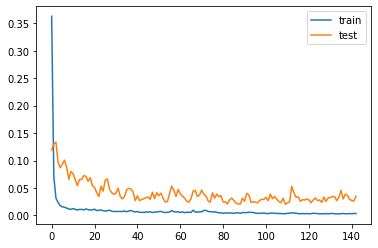

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Predictions

In [ ]:
trainPred = model.predict(x_train)
testPred = model.predict(x_valid)
septPred = model.predict(sept)
print(testPred.shape)
print(trainPred.shape)
print(septPred.shape)

(240, 1)
(263, 1)
(2, 1)


In [ ]:
#Reverting data back to 2D from 3D
x_train_t = x_train.reshape(-1, x_train.shape[2])
#trainPred = trainPred.reshape(-1, trainPred.shape[2]))

x_valid_t = x_valid.reshape(-1, x_valid.shape[2])
#testPred = testPred.reshape((testPred.shape[0], testPred.shape[2]))

print(x_train_t.shape)
print(trainPred.shape)
print(x_valid_t.shape)
print(testPred.shape)

(7890, 10)
(263, 1)
(7200, 10)
(240, 1)


In [ ]:
# invert scaling for forecasted values 

inv_trainPred = scaler_l.inverse_transform(trainPred)
print(inv_trainPred[1])

inv_testPred = scaler_l.inverse_transform(testPred)
print(inv_testPred[1])

# invert scaling for actual values
inv_y_train = scaler_l.inverse_transform(y_train)
print(inv_y_train[1])

inv_y_valid = scaler_l.inverse_transform(y_valid)
print(inv_y_valid[1])

# invert scaling for actual values

inv_sept = scaler_l.inverse_transform(septPred)
print(inv_sept[1])

[16133857.]
[15559216.]
[16377690.6]
[15238952.53333333]
[13468850.]


In [ ]:
print(inv_sept)

[[11778892.]
 [13468850.]]


In [ ]:
# calculate Train RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse1 = sqrt(mean_squared_error(inv_y_train, inv_trainPred))
print('Train RMSE: %.3f' % rmse1)

Train RMSE: 132661.351


In [ ]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse2 = sqrt(mean_squared_error(inv_y_valid, inv_testPred))
print('Test RMSE: %.3f' % rmse2)

Test RMSE: 559490.413


In [ ]:
# calculate Normalized RMSE using std
y_max = y_train.max()
y_min = y_train.min()
nrmse1 = rmse1 /(inv_y_train.mean()) 
print('Train NRMSE using mean:', nrmse1)

Train NRMSE using mean: 0.011083354139407527


In [ ]:
# calculate Normalized RMSE using std
y_max = y_train.max()
y_min = y_train.min()
nrmse2 = rmse1 /(inv_y_train.std()) 
print('Train NRMSE using std:', nrmse2)

Train NRMSE using std: 0.04430763945327737


In [ ]:
# calculate Normalized RMSE using mean
y_max = y_valid.max()
y_min = y_valid.min()
nrmse3 = rmse2 /(inv_y_valid.mean()) 
print('Test NRMSE using mean:', nrmse3)

Test NRMSE using mean: 0.051994843759074545


In [ ]:
# calculate Normalized RMSE using std
y_max = y_valid.max()
y_min = y_valid.min()
nrmse4 = rmse2 /(inv_y_valid.std()) 
print('Test NRMSE using std:', nrmse4)

Test NRMSE using std: 0.16498177934655903


In [ ]:
# calculate R-square
from sklearn.metrics import r2_score
from math import sqrt

r_sq = r2_score(inv_y_valid, inv_testPred)
print('Test R_Square: %.3f' % r_sq)

Test R_Square: 0.973


<BarContainer object of 240 artists>

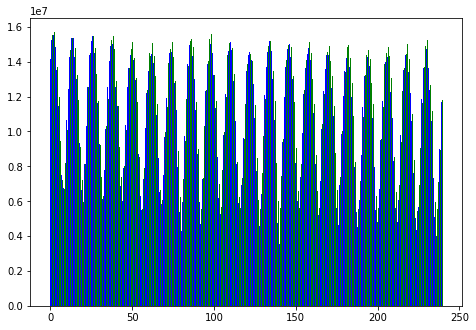

In [ ]:
#1 year's plot
import numpy as np
import matplotlib.pyplot as plt
X = np.arange(len(testPred))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, inv_y_valid.flatten(), color = 'b', width = 0.5)
ax.bar(X + 0.5, inv_testPred.flatten(), color = 'g', width = 0.5)

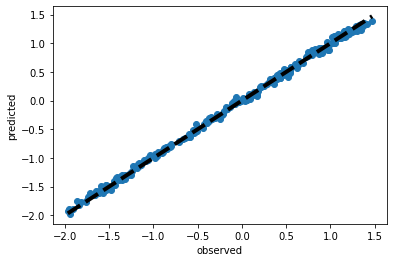

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_train,trainPred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
plt.show()

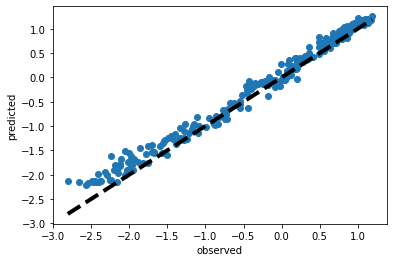

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_valid,testPred) #[:,:,6]
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
#plt.savefig('test_prediction.png',bbox_inches='tight',dpi=1200)
plt.show()

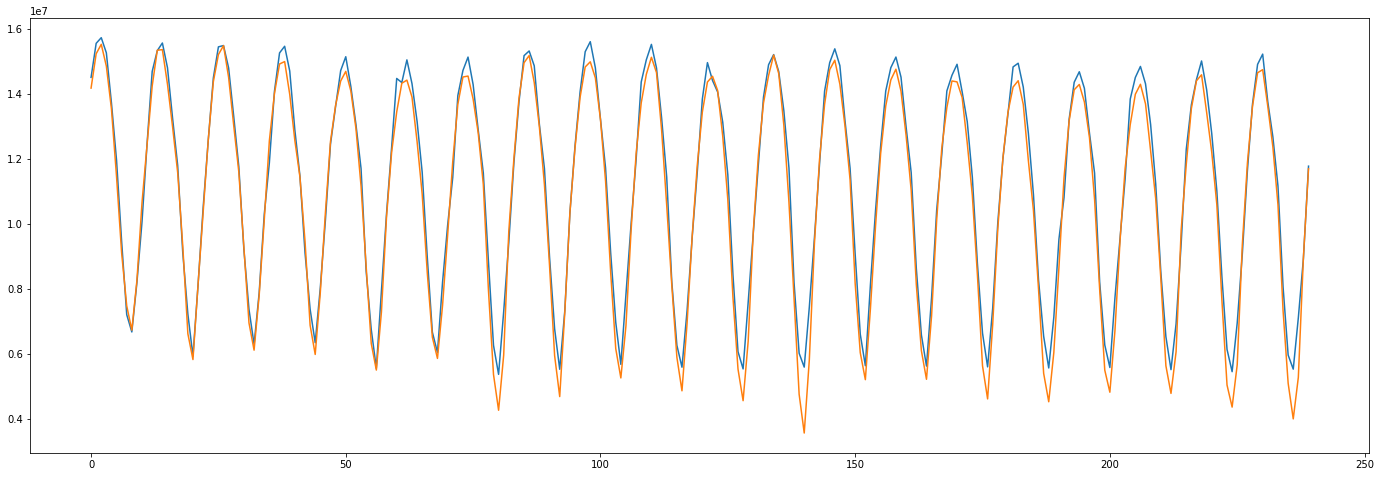

In [ ]:
from matplotlib import pyplot
fig, ax= plt.subplots(figsize=(24, 8))

pyplot.plot(inv_testPred, label='predictions')
pyplot.plot(inv_y_valid, label='observation')
pyplot.show()